# House pricing prediction
#### Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

##### With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

#### The objective of this project is to generate a prediction of the prices.Analyzing and cleaning the data prior to explore and define technique to model.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sb
import sklearn.linear_model
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
#from statsmodels.multivariate.pca import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as lm
%matplotlib inline

### Load data

In [2]:
data=pd.read_csv("./data/train.csv")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Analyze the objective column distribution and frequency. 

In [3]:
data["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

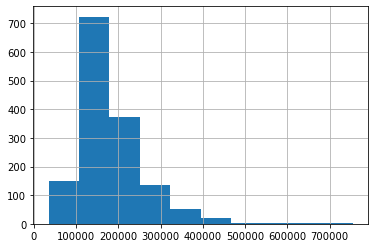

In [4]:
data["SalePrice"].hist()

##### Distribution do not look as a normal distribution. 

In [5]:
import scipy.stats as st
##obtained in stack overflow.
#this is to review which distribution fix better with our goal parameter.
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme","lognorm","beta","invgauss","uniform","gamma","expon","pearson3","triang"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]
get_best_distribution(data['SalePrice'])

p value for norm = 6.402139779190053e-20


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1677: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for exponweib = 0.0
p value for weibull_max = 0.0
p value for weibull_min = 0.0
p value for pareto = 3.795561855165914e-227


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for genextreme = 0.0
p value for lognorm = 0.014705247778226238
p value for beta = 4.448638594770014e-06

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



p value for invgauss = 6.96903963660358e-219
p value for uniform = 0.0
p value for gamma = 0.0
p value for expon = 4.933205313206431e-109
p value for pearson3 = 7.101045838704336e-05
p value for triang = 3.534558675005082e-210
Best fitting distribution: lognorm
Best p value: 0.014705247778226238
Parameters for the best fit: (0.39897548872302213, -129.93222216110172, 166854.6998403497)


('lognorm',
 0.014705247778226238,
 (0.39897548872302213, -129.93222216110172, 166854.6998403497))

### This is a log normal distribution. Log normal can be transformed to Normal distribution.
https://www.youtube.com/watch/eAdfLxTsuRc
https://aegis4048.github.io/transforming-non-normal-distribution-to-normal-distribution


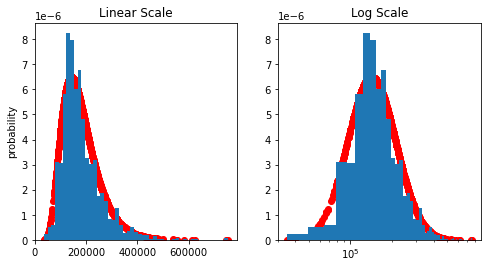

In [6]:
# fit lognormal distribution
SalePrice=data[["SalePrice"]].to_numpy()
shape, loc, scale = stats.lognorm.fit(SalePrice, loc=0)
pdf_lognorm = stats.lognorm.pdf(SalePrice, shape, loc, scale)
# visualize

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.hist(SalePrice, bins='auto', density=True)
ax1.scatter(SalePrice, pdf_lognorm, color = 'r')
ax1.set_ylabel('probability')
ax1.set_title('Linear Scale')

ax2.hist(SalePrice, bins='auto', density=True)
ax2.scatter(SalePrice, pdf_lognorm, color = 'r')
ax2.set_xscale('log')
ax2.set_title('Log Scale');

### Applying Boxcox transformation 

In [7]:
xt, lmbda = stats.boxcox(data["SalePrice"])
#Adding a new column
data["SalePriceLog"]=xt
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,7.932610
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,7.878263
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,7.959618
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,7.774955
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,8.002875


##### Explore numerical data to clean.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
#Categorical
#print values of PoolQC
print(data['PoolQC'].unique())
#Assuming that nan refers to 'NA' which means No pool
data['PoolQC'] = data.PoolQC.fillna('NA')
#print values of PoolQC
print(data['MiscFeature'].unique())
#Assuming that nan refers to 'NA' which means No misc feature.
data['MiscFeature'] = data.MiscFeature.fillna('NA')
#print values for fence
print(data['Fence'].unique())
#Assuming that nan refers to 'NA' which means No fence.
data['Fence'] = data.Fence.fillna('NA')
#print values for Alley
print(data['Alley'].unique())
#Assuming that nan refers to 'NA' which means No alley access.
data['Alley'] = data.Alley.fillna('NA')
#print values for FireplaceQu
print(data['FireplaceQu'].unique())
#Assuming that nan refers to 'NA' which means No fire place.
data['FireplaceQu'] = data.FireplaceQu.fillna('NA')
#print values for Garage
print(data['GarageQual'].unique())
print(data['GarageCond'].unique()) 
print(data['GarageType'].unique())  
print(data['GarageFinish'].unique()) 
#Assuming that nan refers to 'NA' which means No Garage.
data['GarageQual'] = data.GarageQual.fillna('NA')
data['GarageCond'] = data.GarageCond.fillna('NA')
data['GarageType'] = data.GarageType.fillna('NA')
data['GarageFinish'] = data.GarageFinish.fillna('NA')

#print values for Basement
print(data['BsmtQual'].unique())   
print(data['BsmtCond'].unique()) 
print(data['BsmtFinType1'].unique())  
print(data['BsmtFinType2'].unique()) 
print(data['BsmtExposure'].unique())  
#Assuming that nan refers to 'NA' which means No Basement.
data['BsmtQual'] = data.BsmtQual.fillna('NA')
data['BsmtCond'] = data.BsmtCond.fillna('NA')
data['BsmtFinType1'] = data.BsmtFinType1.fillna('NA')
data['BsmtFinType2'] = data.BsmtFinType2.fillna('NA')
data['BsmtExposure'] = data.BsmtExposure.fillna('NA')
#print value for Massonery Vnr type assume 'NA'is none
print(data['MasVnrType'].unique())  
#Assuming that nan refers to 'None'.
data['MasVnrType'] = data.MasVnrType.fillna('None')
 #print values for electrical there is no intepretation for NA in electrical
print(data['Electrical'].unique())
#dropping row without this data
data=data[data.Electrical.notnull()]
#Numeric Values
#As this depends on there is no Massonery or Garage will be 0
print(data['GarageYrBlt'].unique())
data['GarageYrBlt'] = data.GarageYrBlt.fillna(0)
print(data['MasVnrArea'].unique())
data['MasVnrArea'] = data.MasVnrArea.fillna(0)

#print values for LotFrontage
print(data['LotFrontage'].unique())


[nan 'Ex' 'Fa' 'Gd']
[nan 'Shed' 'Gar2' 'Othr' 'TenC']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[nan 'Grvl' 'Pave']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
['RFn' 'Unf' 'Fin' nan]
['Gd' 'TA' 'Ex' nan 'Fa']
['TA' 'Gd' nan 'Fa' 'Po']
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['No' 'Gd' 'Mn' 'Av' nan]
['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
[2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.   nan 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 

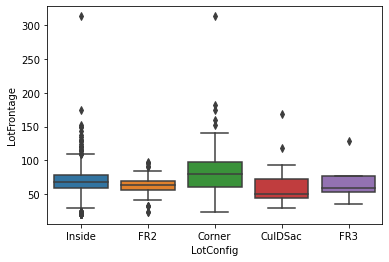

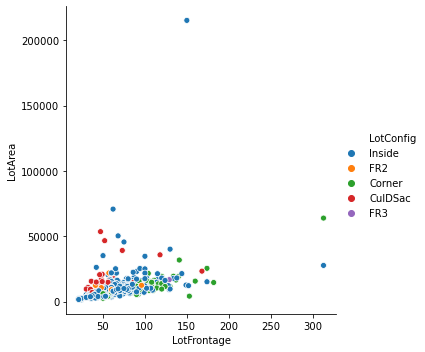

0

In [10]:
#Review data relation with lotfrontage
data2=data[data.LotFrontage.notnull()]

data2.corr()
sb.boxplot( y=data2["LotFrontage"], x=data2["LotConfig"] );
plt.show()
sb.relplot(x="LotFrontage", y="LotArea", hue="LotConfig",    data=data2);
plt.show()
#fill with lot config means
data['LotFrontage'] = data.groupby('LotConfig')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
data['LotFrontage'].unique()
data['LotFrontage'].isna().sum()
#plt.scatter(data2.LotFrontage,data2.LotArea)
#plt.scatter(data.LotFrontage,data['Neighborhood'])
#data2=data._get_numeric_data()
#sb.set(style="ticks", color_codes=True)
#g = sb.pairplot(data2)
#fig, ax = plt.subplots(figsize=(20, 10))
#sb.heatmap(data.isnull(), yticklabels=False, cbar=True)
#plt.show()

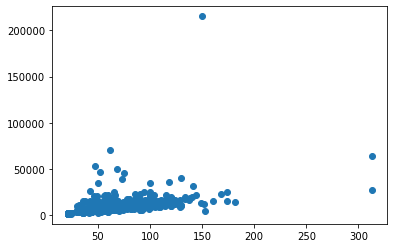

In [11]:
data=data[data['LotConfig']=='Inside']
plt.scatter(data2['LotFrontage'],data2['LotArea'])

In [12]:
# skewness along the index axis 

print(data.skew(axis = 0, skipna = True).sort_values())

#delete max outlayer in 'lotArea'
data[data['LotArea']==max(data.LotArea)]

GarageYrBlt      -3.661313
YearBuilt        -0.535178
YearRemodAdd     -0.467603
GarageCars       -0.266445
SalePriceLog     -0.084213
Id               -0.002180
FullBath          0.017586
YrSold            0.098489
OverallQual       0.181539
MoSold            0.184347
GarageArea        0.213554
BedroomAbvGr      0.287231
TotalBsmtSF       0.656078
BsmtFullBath      0.667315
TotRmsAbvGrd      0.678435
Fireplaces        0.696312
HalfBath          0.754220
OverallCond       0.798774
2ndFlrSF          0.808971
BsmtFinSF1        0.827883
BsmtUnfSF         0.942074
1stFlrSF          0.961105
GrLivArea         1.050930
MSSubClass        1.336634
WoodDeckSF        1.578922
SalePrice         1.583693
LotFrontage       2.008930
OpenPorchSF       2.463888
MasVnrArea        2.675895
EnclosedPorch     2.928103
ScreenPorch       3.973131
BsmtHalfBath      4.173185
BsmtFinSF2        4.369197
KitchenAbvGr      4.532964
LowQualFinSF      9.035263
3SsnPorch        10.753066
LotArea          16.499097
M

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog
313,314,20,RL,150.0,215245,Pave,NA,IR3,Low,AllPub,...,NA,NA,NA,0,6,2009,WD,Normal,375000,8.156325


In [13]:
data[data['LotArea']>30000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog
53,54,20,RL,68.000000,50271,Pave,NA,IR1,Low,AllPub,...,NA,NA,NA,0,11,2006,WD,Normal,385000,8.166120
313,314,20,RL,150.000000,215245,Pave,NA,IR3,Low,AllPub,...,NA,NA,NA,0,6,2009,WD,Normal,375000,8.156325
411,412,190,RL,100.000000,34650,Pave,NA,Reg,Bnk,AllPub,...,NA,NA,NA,0,1,2006,WD,Normal,145000,7.789039
451,452,20,RL,62.000000,70761,Pave,NA,IR1,Low,AllPub,...,NA,NA,NA,0,12,2006,WD,Normal,280000,8.046247
523,524,60,RL,130.000000,40094,Pave,NA,IR1,Bnk,AllPub,...,NA,NA,NA,0,10,2007,New,Partial,184750,7.885251
848,849,50,RL,75.000000,45600,Pave,NA,IR2,Bnk,AllPub,...,NA,NA,NA,0,9,2008,WD,Normal,240000,7.987158
1184,1185,20,RL,50.000000,35133,Grvl,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,5,2007,WD,Normal,186700,7.889380
1190,1191,190,RL,67.709924,32463,Pave,NA,Reg,Low,AllPub,...,NA,NA,NA,0,3,2007,WD,Normal,168000,7.847722
1287,1288,20,RL,67.709924,36500,Pave,NA,IR1,Low,AllPub,...,NA,NA,NA,0,6,2006,WD,Normal,190000,7.896263
1396,1397,20,RL,67.709924,57200,Pave,NA,IR1,Bnk,AllPub,...,NA,NA,NA,0,6,2010,WD,Normal,160000,7.828349


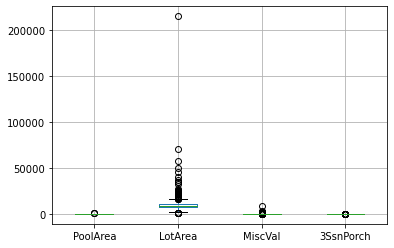

In [14]:
data.boxplot(['PoolArea','LotArea','MiscVal','3SsnPorch'])


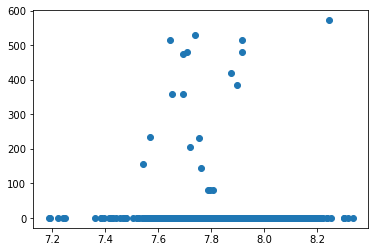

In [15]:
#delete outlayer
data=data[data.LotArea<30000].reset_index()
#xt, lmbda = stats.boxcox(data["PoolArea"])
#data["PoolArea"]=xt
plt.scatter(data.SalePriceLog,data['LowQualFinSF'])


In [16]:
#Sumarizing PArameters
data['Quality'] = data['OverallQual'] + data['OverallCond']
data['builtArea'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['Bathrooms'] = data['FullBath'] +data['BsmtFullBath'] + (1/2 * data['BsmtHalfBath']) +  (1/2 * data['HalfBath'])

## ANOVA using OLS model to identify the categorical data
#### With this test we want to analyze the significance of the categorical parameters in our goal SalesPrice
https://www.analyticsvidhya.com/blog/2020/06/introduction-anova-statistics-data-science-covid-python/

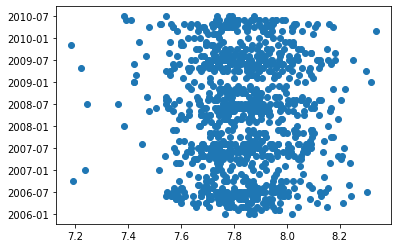

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'datesold'], dtype=object)

In [17]:
#based on piar plot and corr matrix month and year will be managed as categorical parameters.
data['datesold']=data['MoSold'].astype(str)+'-'+data['YrSold'].astype(str)
data['MoSold']=data['MoSold'].astype(str)
data['YrSold']=data['YrSold'].astype(str)
data['datesold'] = pd.to_datetime(data['datesold'], format = '%m-%Y')
plt.scatter(data['SalePriceLog'],data['datesold'])
plt.show()
data.select_dtypes(include=['object']).columns.values
categorical_col=np.append(data.select_dtypes(include=['object']).columns.values,'datesold')
categorical_col


In [18]:

df = pd.DataFrame(columns=['Categoricalparam','pvalue'])
cadena=''
for elem in categorical_col:
    cadena=cadena+'C('+elem+')+'
cadena=cadena[:-1]
cadena='C(MSZoning)'
for elem in categorical_col:
    model = ols('SalePriceLog ~C('+elem+')', data).fit()
    model.f_pvalue
    df = df.append({'Categoricalparam': elem,'pvalue':model.f_pvalue}, ignore_index=True)
df=df[(df['Categoricalparam']!='Utilities') & (df['Categoricalparam']!='LotConfig') ]
df.sort_values(by='pvalue')

#data.isna().sum()
#model = ols('SalePriceLog ~C('+'LotConfig'+')', data).fit()
#model.summary()) 
#model.pvalues
#fres = model.f_test()
#dir(fres)
#fres.fvalue
#fres.pvalue

,Categoricalparam,pvalue
8,Neighborhood,8.94676e-175
18,ExterQual,7.52098e-147
30,KitchenQual,2.40284e-143
21,BsmtQual,1.07448e-130
34,GarageFinish,2.24856e-113
33,GarageType,5.89623e-92
20,Foundation,5.45174e-87
32,FireplaceQu,7.22212e-75
27,HeatingQC,6.36437e-68
24,BsmtFinType1,1.06848e-62


In [19]:
#Utilities and Lot Config only has one value,and our anova pvalue test gave us a nan we will discard this columns as they are not significant.
##Pvalue<.05. we can reject the Null Hypothesis that there’s no difference among different  groups.

In [20]:
categorical_param=['Neighborhood','ExterQual','GarageFinish','GarageType','Foundation','HeatingQC','MSZoning','MasVnrType','SaleCondition','SaleType']
#Making dummies
data_dummies=pd.get_dummies(data=data[categorical_param], drop_first=True)
data_dummies.head()

,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Identify the significant numerical parameters. 

In [21]:
#Correlation
data_clean=data.copy()
#Drop columns that were summarized
data_clean=data_clean.drop('OverallCond', 1)
data_clean=data_clean.drop('TotalBsmtSF', 1)
data_clean=data_clean.drop('1stFlrSF', 1)
data_clean=data_clean.drop('2ndFlrSF', 1)
data_clean=data_clean.drop('FullBath', 1)
data_clean=data_clean.drop('BsmtHalfBath', 1)
data_clean=data_clean.drop('HalfBath', 1)
data_clean=data_clean.drop('BsmtFullBath', 1)
data_clean.corr()['SalePriceLog'].sort_values()
data.head()


,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog,Quality,builtArea,Bathrooms,datesold
0,0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,...,2,2008,WD,Normal,208500,7.932610,12,2566,3.5,2008-02-01
1,2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,...,9,2008,WD,Normal,223500,7.959618,12,2706,3.5,2008-09-01
2,5,6,50,RL,85.0,14115,Pave,NA,IR1,Lvl,...,10,2009,WD,Normal,143000,7.783469,10,2158,2.5,2009-10-01
3,6,7,20,RL,75.0,10084,Pave,NA,Reg,Lvl,...,8,2007,WD,Normal,307000,8.081202,13,3380,3.0,2007-08-01
4,8,9,50,RM,51.0,6120,Pave,NA,Reg,Lvl,...,4,2008,WD,Abnorml,129900,7.744773,12,2726,2.0,2008-04-01


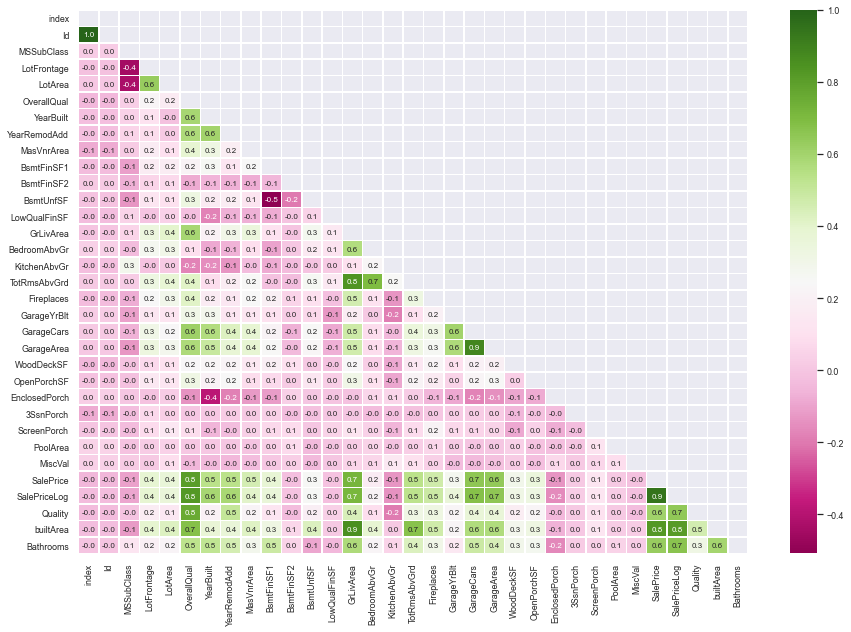

In [22]:
#sb.set_theme(style="white")

sb.set(font_scale=0.8)
# Compute the correlation matrix
corr = data_clean._get_numeric_data().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))


plt.figure(figsize=(15, 10))
ax = sb.heatmap(corr,mask=mask, annot=True, annot_kws={'size': 8}, fmt='.1f', cmap='PiYG', linewidths=.5)

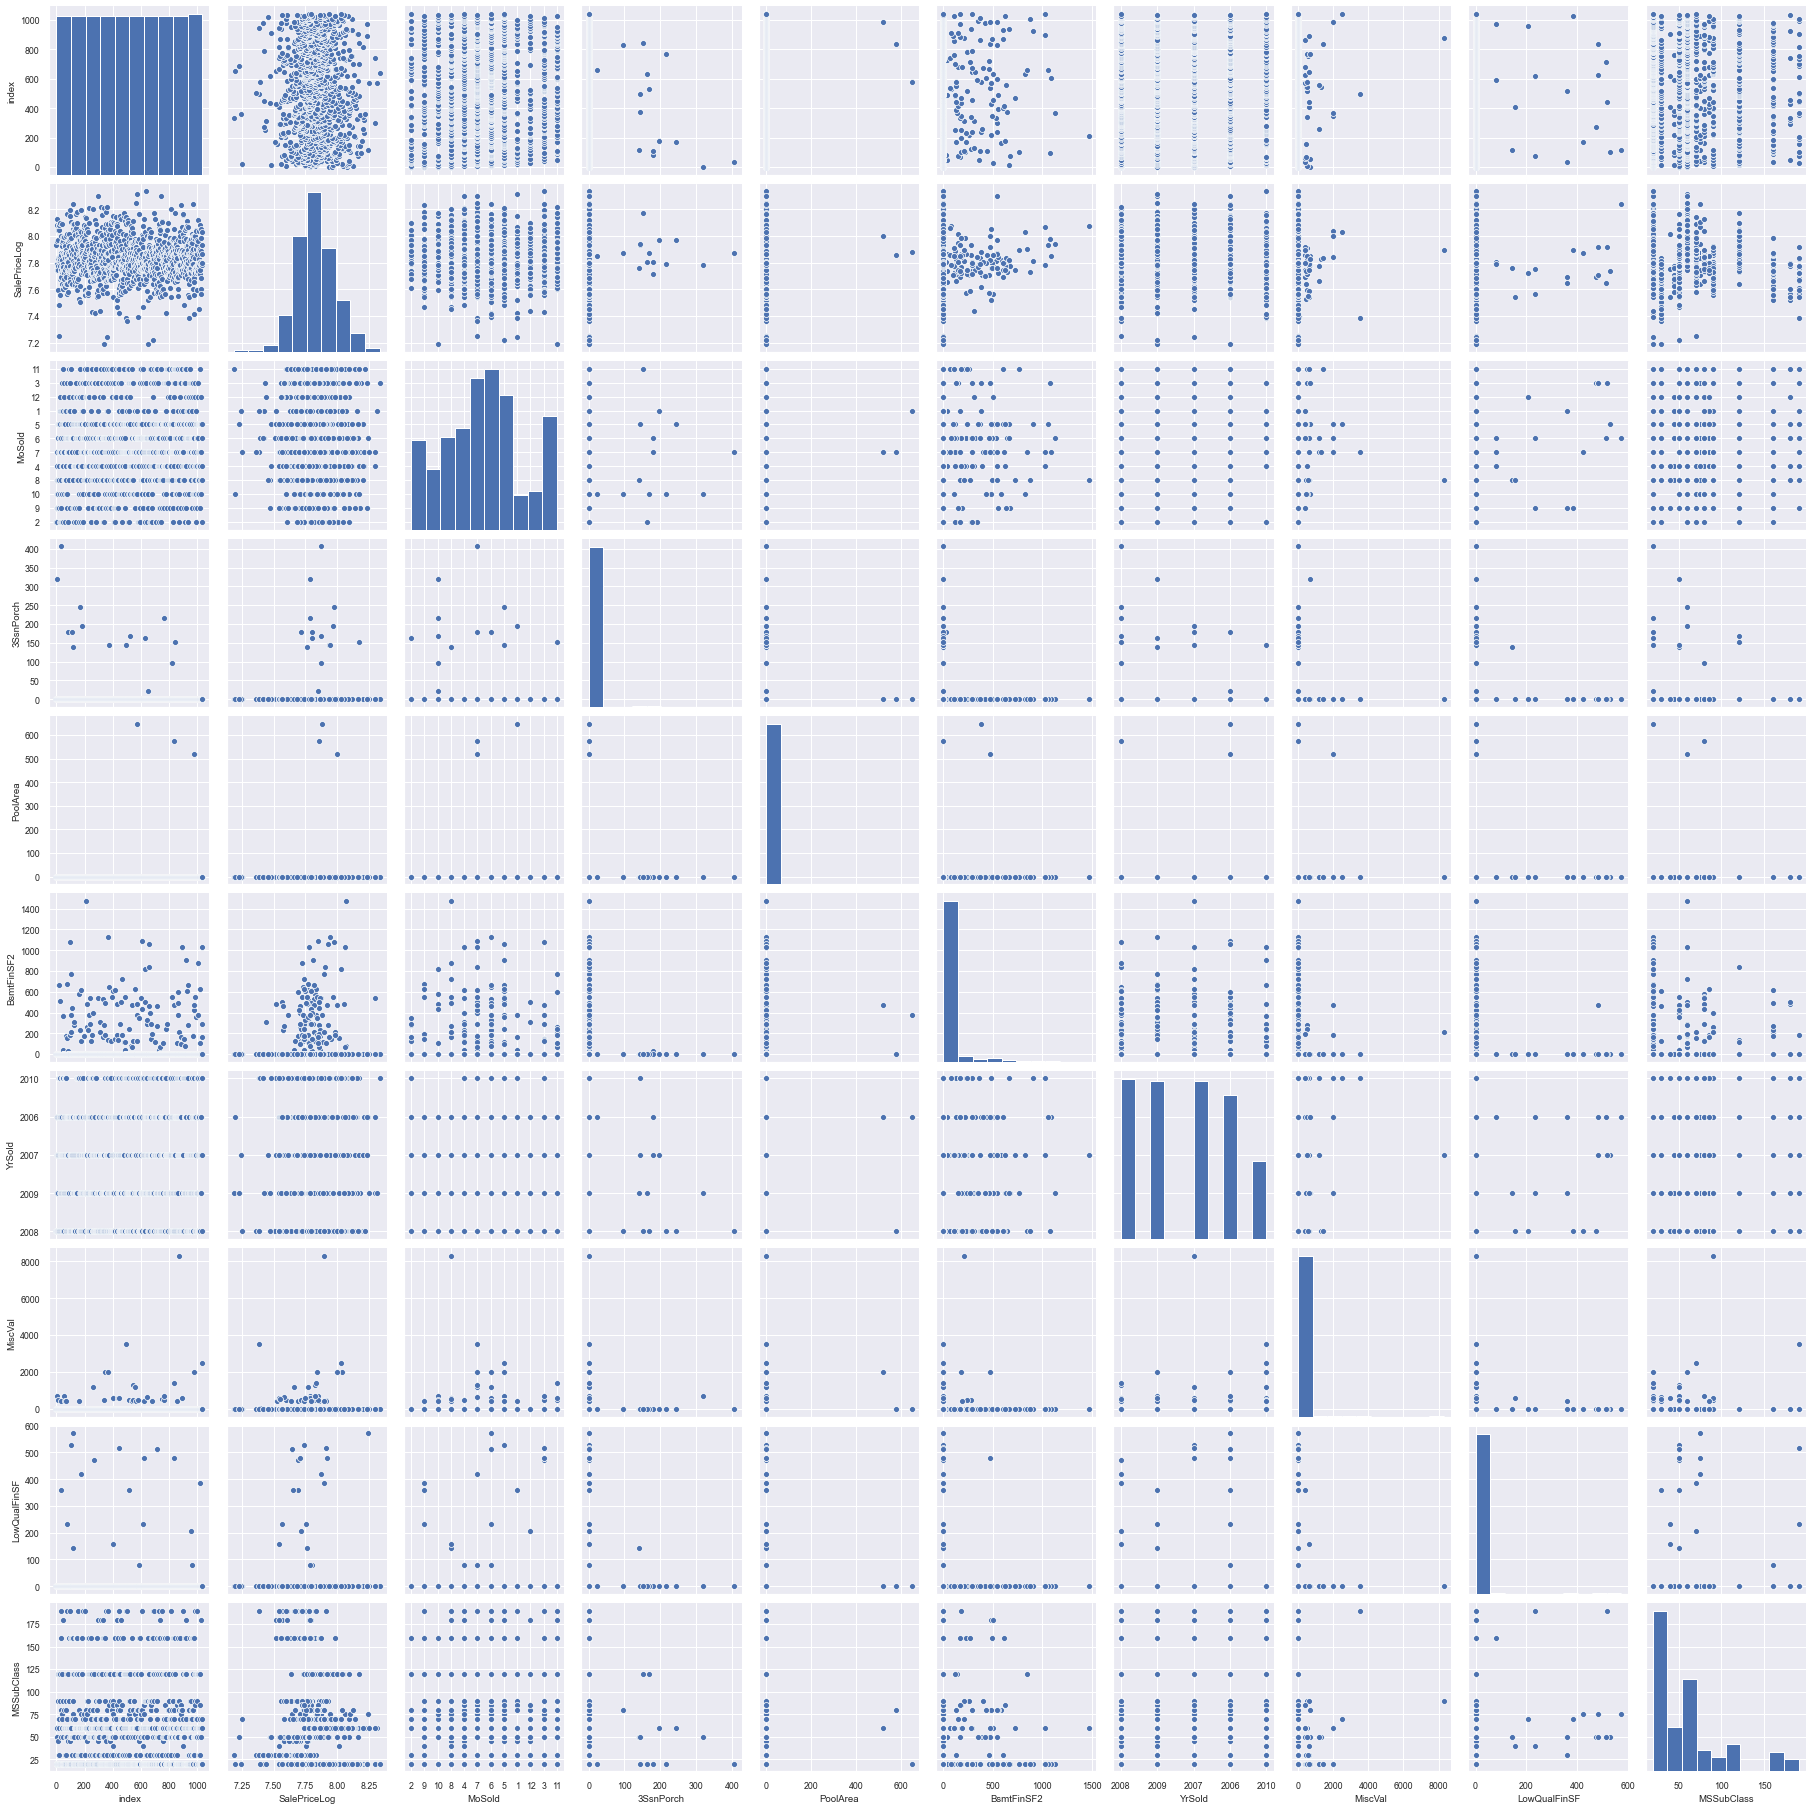

In [23]:
#No significant data

data_no_significant=data_clean[['SalePriceLog', 'MoSold','3SsnPorch','PoolArea','BsmtFinSF2','YrSold','MiscVal','LowQualFinSF','MSSubClass']].reset_index()
data_no_significant.head()
sb.pairplot(data_no_significant)


####  I identify month and year as categorical, I will add them to the OLS ANOVA.
#### Parameters LowQualiFinSF,MscVal,BsmtFinSF2,PoolArea and 3SsnPorch will be dropped.

In [24]:
columns_no=data_clean.drop(['SalePriceLog','SalePrice','index'], 1)._get_numeric_data().columns.values
#independent parameters
X=sm.add_constant(data_clean[columns_no])
#dependent parameter
Y=data_clean['SalePriceLog']
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
model.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePriceLog   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     289.7
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:42:01   Log-Likelihood:                 1596.1
No. Observations:                1041   AIC:                            -3132.
Df Residuals:                    1011   BIC:                            -2984.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.8350      0.235     16.297      0.000       3.373       4.297
Id              -1.9e-06   4.03e-06     -0.472      0.637   -9.81e-06    6.01e-06
MSSubClass    -9.439e-05   5.12e-05     -1.844      0.065      -0.000    6.04e-06
LotFrontage       0.0004      0.000      3.157      0.002       0.000       0.001
LotArea        1.962e-06   6.46e-07      3.038      0.002    6.95e-07    3.23e-06
OverallQual       0.0075      0.003      2.350      0.019       0.001       0.014
YearBuilt         0.0012      0.000     11.240      0.000       0.001       0.001
YearRemodAdd      0.0005      0.000      3.803      0.000       0.000       0.001
MasVnrArea    -7.571e-06   1.13e-05     -0.667      0.505   -2.98e-05    1.47e-05
BsmtFinSF1     2.728e-05   7.62e-06      3.579      0.000    1.23e-05    4.22e-05
BsmtFinSF2    -2.501e-06   1.11e-05     -0.225      0.822   -2.43e-05    1.93e-05
BsmtUnfSF     -2.154e-06   7.54e-06     -0.286      0.775    -1.7e-05    1.26e-05
LowQualFinSF   2.134e-05   2.91e-05      0.732      0.464   -3.58e-05    7.85e-05
GrLivArea      4.821e-05    9.3e-06      5.187      0.000       3e-05    6.65e-05
BedroomAbvGr     -0.0065      0.003     -2.103      0.036      -0.013      -0.000
KitchenAbvGr     -0.0197      0.009     -2.137      0.033      -0.038      -0.002
TotRmsAbvGrd      0.0045      0.002      1.977      0.048    3.27e-05       0.009
Fireplaces        0.0097      0.003      2.974      0.003       0.003       0.016
GarageYrBlt    1.426e-05   4.79e-06      2.977      0.003    4.86e-06    2.37e-05
GarageCars        0.0090      0.005      1.643      0.101      -0.002       0.020
GarageArea     1.974e-05   1.77e-05      1.116      0.265    -1.5e-05    5.45e-05
WoodDeckSF     2.623e-05   1.55e-05      1.697      0.090    -4.1e-06    5.66e-05
OpenPorchSF    3.933e-06   2.91e-05      0.135      0.892   -5.31e-05     6.1e-05
EnclosedPorch  7.068e-05   3.21e-05      2.199      0.028    7.62e-06       0.000
3SsnPorch      5.937e-05   6.82e-05      0.870      0.385   -7.45e-05       0.000
ScreenPorch       0.0001   3.23e-05      3.613      0.000    5.33e-05       0.000
PoolArea      -1.855e-05   5.35e-05     -0.347      0.729      -0.000    8.64e-05
MiscVal       -1.063e-05   5.21e-06     -2.043      0.041   -2.08e-05   -4.18e-07
Quality           0.0221      0.002     11.210      0.000       0.018       0.026
builtArea      4.949e-05   6.87e-06      7.201      0.000     3.6e-05     6.3e-05
Bathrooms         0.0140      0.004      3.810      0.000       0.007       0.021
==============================================================================
Omnibus:                      373.467   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2720.762
Skew:                          -1.456   Prob(JB):         

 ### If p<|t|  is less than .05 we conclude that the parameters influence the goal parameter SalesPrice
 #### We will discard:
 #### Id,MasVnrArea,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GarageCars,GarageArea,OpenPorchSF,WoodDeckSF,3SsnPorch,PoolArea,MSSubClass	

# Applying PCA non categorical parameters 

In [25]:
columns_no_significant=['Id','MasVnrArea','BsmtFinSF2','BsmtUnfSF','LowQualFinSF','GarageCars','GarageArea','OpenPorchSF','WoodDeckSF','3SsnPorch','PoolArea','MSSubClass']
#discard columns
data_clean=data_clean.drop(columns_no_significant,1)
data_clean.columns


Index(['index', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch',
       'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold',
       'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'SalePriceLog',
       'Quality', 'builtArea', 'Bathrooms', 'datesold']

In [26]:
data_clean_no=data_clean._get_numeric_data()
#numeric_columns = [x for x in data_clean_no if x not in ['SalePriceLog','SalePrice']]
data_clean_numeric = data_clean_no.copy()
data_clean_numeric=data_clean_numeric.drop('SalePriceLog',1)
data_clean_numeric=data_clean_numeric.drop('SalePrice',1)
#data_clean_numeric=data_clean_numeric.drop('level_0',1)

data_clean_numeric.shape
#normalizamos los datos
scaler=StandardScaler()
df = data_clean_numeric
scaler.fit(df) # calculo la media para poder hacer la transformacion
X_scaled=scaler.transform(df)# Ahora si, escalo los datos y los normalizo

data.isna().sum()
data_clean_numeric.isna().sum()

index            0
LotFrontage      0
LotArea          0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
BsmtFinSF1       0
GrLivArea        0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
EnclosedPorch    0
ScreenPorch      0
MiscVal          0
Quality          0
builtArea        0
Bathrooms        0
dtype: int64

shape of X_pca (1041, 14)
[0.28337251 0.13003894 0.07600339 0.06714993 0.05619949 0.05413503
 0.05257747 0.04795334 0.04444101 0.03673562 0.03319096 0.03051038
 0.0204702  0.01991172]
suma: 0.9327782753857842


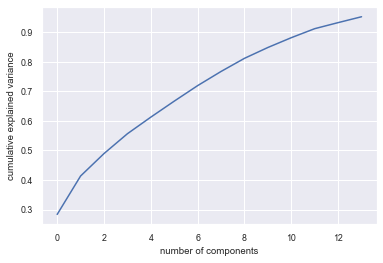

In [27]:

pca=PCA(0.95)
pca.fit(X_scaled) # obtener los componentes principales
X_pca=pca.transform(X_scaled) # convertimos nuestros datos con las nuevas dimensiones de PCA

print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:13]))
#Vemos que con 13 componentes tenemos algo mas del 95% de varianza explicada
 
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [28]:
principal_C = pd.DataFrame(data = X_pca
             , columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14'])
principal_C['Ytrain']=data_clean['SalePriceLog']

principal_C
#data.isna().sum()
#data_clean.isna().sum()
#data['SalePriceLog'][1]
#print(data_clean['SalePriceLog'].unique())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,Ytrain
0,-1.659313,-1.055749,1.197691,0.806894,-0.366608,-1.367180,0.011709,0.444497,-0.528602,-0.528342,-1.243919,-0.040098,0.297220,-0.023253,7.932610
1,-1.872682,-1.043202,0.227279,0.599366,-0.257102,-1.456801,0.017992,0.569064,-0.408949,0.275454,-0.241458,-0.628260,0.717065,0.169718,7.959618
2,0.660172,-1.073962,-1.172011,2.342280,0.250643,-0.857803,1.110708,2.553868,0.254914,-0.225304,-0.362235,-0.506450,0.605491,-1.116275,7.783469
3,-2.916603,-1.458922,-0.121403,1.068144,-0.095593,-1.704272,0.737475,-0.011603,-0.577434,0.033151,-0.357272,0.474957,-0.183324,0.358157,8.081202
4,0.208394,2.701965,1.394523,-1.316385,1.552421,-2.421056,1.813549,-0.229801,-2.269462,-0.877819,4.102631,-0.941207,-0.766381,-0.225283,7.744773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,-0.600791,-0.432531,0.776990,-0.357686,-0.128109,1.840578,-0.691768,-0.222576,0.132509,0.635531,0.360250,-1.009289,0.260756,0.179201,7.863875
1037,-2.697516,0.440673,-1.081237,0.666465,-0.105725,1.404261,0.260393,-1.106936,-0.002430,1.309840,1.020659,-0.249505,0.392916,0.106219,7.935404
1038,-3.365649,2.055031,0.665241,-0.999077,5.008709,2.902378,1.976042,3.831673,0.609584,2.839185,-0.455421,1.920973,0.234731,0.950124,8.027382
1039,1.856852,-0.078209,-0.263134,-0.759568,-0.521349,1.706129,1.304520,-0.140886,0.541421,-0.945831,0.205805,-0.771365,0.586641,-0.321650,7.781006


In [29]:
columns_no=principal_C.drop(['Ytrain'], 1).columns.values
#independent parameters
X=sm.add_constant(principal_C[columns_no])
#dependent parameter
Y=principal_C['Ytrain']
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
model.summary()

##The current simplification is not quite needed the Rsquared is better if we have all the values.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Ytrain   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     568.2
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:42:01   Log-Likelihood:                 1564.0
No. Observations:                1041   AIC:                            -3098.
Df Residuals:                    1026   BIC:                            -3024.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8323      0.002   4657.928      0.000       7.829       7.836
PC1           -0.0626      0.001    -86.331      0.000      -0.064      -0.061
PC2           -0.0213      0.001    -19.934      0.000      -0.023      -0.019
PC3           -0.0030      0.001     -2.117      0.035      -0.006      -0.000
PC4           -0.0038      0.001     -2.568      0.010      -0.007      -0.001
PC5           -0.0015      0.002     -0.940      0.348      -0.005       0.002
PC6        -3.621e-05      0.002     -0.022      0.983      -0.003       0.003
PC7            0.0083      0.002      4.913      0.000       0.005       0.012
PC8            0.0006      0.002      0.356      0.722      -0.003       0.004
PC9           -0.0003      0.002     -0.160      0.873      -0.004       0.003
PC10          -0.0096      0.002     -4.788      0.000      -0.014      -0.006
PC11           0.0010      0.002      0.470      0.638      -0.003       0.005
PC12          -0.0012      0.002     -0.559      0.576      -0.006       0.003
PC13          -0.0122      0.003     -4.518      0.000      -0.017      -0.007
PC14          -0.0134      0.003     -4.911      0.000      -0.019      -0.008
==============================================================================
Omnibus:                      352.294   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2188.958
Skew:                          -1.411   Prob(JB):                         0.00
Kurtosis:                       9.520   Cond. No.                         3.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Mixing the  analyzed most significant categorical parameters as dummies and the most significant continuos parameters in a regression 

In [30]:
Y=data_clean['SalePriceLog']
column_names_numeric=data_clean_numeric.columns
data_clean_numeric[data_dummies.columns] = data_dummies[data_dummies.columns]


In [31]:
data_clean_numeric=data_clean_numeric.drop('index',1)
X=data_clean_numeric

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(624, 83)
(417, 83)
(624,)
(417,)


In [33]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
# print the intercept
print(model.intercept_)

5.223528075414537


In [34]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
LotFrontage,0.000300
LotArea,0.000002
OverallQual,-0.003007
YearBuilt,0.000922
YearRemodAdd,-0.000108
...,...
SaleType_ConLI,-0.082643
SaleType_ConLw,-0.055682
SaleType_New,0.212137
SaleType_Oth,0.086701


In [35]:
predictions = model.predict(X_test)
predictions

array([8.0639232 , 7.8115197 , 7.88480604, 8.18210846, 7.91089017,
       7.92382625, 8.02513214, 7.92420103, 8.09899711, 8.0870695 ,
       7.92324852, 7.89657814, 7.9375879 , 7.89848227, 7.63049171,
       8.03686157, 7.8010546 , 7.68386682, 7.97894725, 7.76274038,
       7.71593689, 7.75309234, 7.96050843, 7.69903961, 7.76071808,
       7.69126394, 7.73265081, 7.91358926, 7.9367035 , 7.85485964,
       7.74993926, 7.84818288, 8.12667556, 7.96438842, 7.78091251,
       7.64710788, 7.77478667, 7.74048854, 7.93586448, 7.83485724,
       7.67707445, 7.59582242, 7.67616678, 7.74749704, 7.8097301 ,
       7.8317503 , 7.78985349, 7.74480169, 7.84152378, 7.49955139,
       7.61841147, 7.76823107, 7.93320094, 7.77452538, 8.03938394,
       7.7229037 , 7.68607345, 7.89330772, 7.6047162 , 7.42707392,
       7.99350892, 7.71207269, 7.57114893, 7.7040072 , 7.74222987,
       7.65711644, 7.94247407, 7.88144256, 7.76162168, 7.72000692,
       7.85234931, 7.64536374, 7.64376098, 7.63647651, 7.82780

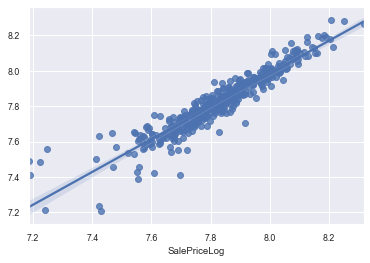

In [36]:
sb.regplot(y_test,predictions)

In [37]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:           SalePriceLog   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     86.49
Date:                Sun, 31 Jan 2021   Prob (F-statistic):          9.35e-262
Time:                        00:42:02   Log-Likelihood:                 1116.2
No. Observations:                 624   AIC:                            -2068.
Df Residuals:                     542   BIC:                            -1705.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.22

In [38]:
#https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c
#We have a better Rsquared with this model.

# Testing the regression


In [39]:
data5=pd.read_csv("./data/test.csv")
data5

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [40]:
#fixing things
#Categorical
#print values of PoolQC
print(data5['PoolQC'].unique())
#Assuming that nan refers to 'NA' which means No pool
data5['PoolQC'] = data5.PoolQC.fillna('NA')
#print values of PoolQC
print(data5['MiscFeature'].unique())
#Assuming that nan refers to 'NA' which means No misc feature.
data5['MiscFeature'] = data5.MiscFeature.fillna('NA')
#print values for fence
print(data5['Fence'].unique())
#Assuming that nan refers to 'NA' which means No fence.
data5['Fence'] = data5.Fence.fillna('NA')
#print values for Alley
print(data5['Alley'].unique())
#Assuming that nan refers to 'NA' which means No alley access.
data5['Alley'] = data5.Alley.fillna('NA')
#print values for FireplaceQu
print(data5['FireplaceQu'].unique())
#Assuming that nan refers to 'NA' which means No fire place.
data5['FireplaceQu'] = data5.FireplaceQu.fillna('NA')
#print values for Garage
print(data5['GarageQual'].unique())
print(data5['GarageCond'].unique()) 
print(data5['GarageType'].unique())  
print(data5['GarageFinish'].unique()) 
#Assuming that nan refers to 'NA' which means No Garage.
data5['GarageQual'] = data5.GarageQual.fillna('NA')
data5['GarageCond'] = data5.GarageCond.fillna('NA')
data5['GarageType'] = data5.GarageType.fillna('NA')
data5['GarageFinish'] = data5.GarageFinish.fillna('NA')

#print values for Basement
print(data5['BsmtQual'].unique())   
print(data5['BsmtCond'].unique()) 
print(data5['BsmtFinType1'].unique())  
print(data5['BsmtFinType2'].unique()) 
print(data5['BsmtExposure'].unique())  
#Assuming that nan refers to 'NA' which means No Basement.
data5['BsmtQual'] = data5.BsmtQual.fillna('NA')
data5['BsmtCond'] = data5.BsmtCond.fillna('NA')
data5['BsmtFinType1'] = data5.BsmtFinType1.fillna('NA')
data5['BsmtFinType2'] = data5.BsmtFinType2.fillna('NA')
data5['BsmtExposure'] = data5.BsmtExposure.fillna('NA')
#print value for Massonery Vnr type assume 'NA'is none
print(data5['MasVnrType'].unique())  
#Assuming that nan refers to 'None'.
data5['MasVnrType'] = data5.MasVnrType.fillna('None')
 #print values for electrical there is no intepretation for NA in electrical
print(data5['Electrical'].unique())
#dropping row without this data
data5=data5[data5.Electrical.notnull()]
#Numeric Values
#As this depends on there is no Massonery or Garage will be 0
print(data5['GarageYrBlt'].unique())
data5['GarageYrBlt'] = data5.GarageYrBlt.fillna(0)
print(data5['MasVnrArea'].unique())
data['MasVnrArea'] = data.MasVnrArea.fillna(0)

#print values for LotFrontage
print(data5['LotFrontage'].unique())

[nan 'Ex' 'Gd']
[nan 'Gar2' 'Shed' 'Othr']
['MnPrv' nan 'GdPrv' 'GdWo' 'MnWw']
[nan 'Pave' 'Grvl']
[nan 'TA' 'Gd' 'Po' 'Fa' 'Ex']
['TA' nan 'Fa' 'Gd' 'Po']
['TA' nan 'Fa' 'Gd' 'Po' 'Ex']
['Attchd' 'Detchd' 'BuiltIn' nan 'Basment' '2Types' 'CarPort']
['Unf' 'Fin' 'RFn' nan]
['TA' 'Gd' 'Ex' 'Fa' nan]
['TA' 'Po' 'Fa' 'Gd' nan]
['Rec' 'ALQ' 'GLQ' 'Unf' 'BLQ' 'LwQ' nan]
['LwQ' 'Unf' 'Rec' 'BLQ' 'GLQ' 'ALQ' nan]
['No' 'Gd' 'Mn' 'Av' nan]
['None' 'BrkFace' 'Stone' 'BrkCmn' nan]
['SBrkr' 'FuseA' 'FuseF' 'FuseP']
[1961. 1958. 1997. 1998. 1992. 1993. 1990. 1970. 1999. 1971. 1975. 2009.
 2005. 2003. 2002. 2006. 2004. 1920. 1974. 2000. 2010. 1967. 1978. 1966.
 1964.   nan 1994. 1949. 1959. 1956. 1952. 1955. 1989. 1950. 1960. 1963.
 1900. 1957. 1938. 1948. 1962. 1928. 1930. 1926. 1939. 1973. 1942. 1979.
 1923. 1915. 1917. 1940. 1910. 1969. 1968. 1977. 1945. 1987. 1947. 1954.
 1941. 1951. 1896. 1976. 2008. 2007. 1965. 2001. 1972. 1984. 1985. 1996.
 1995. 1980. 1986. 1981. 1982. 1991. 1988. 1953. 192

In [41]:
data5['LotFrontage'] = data5.groupby('LotConfig')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
data5['MSZoning'] = data5.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
data5['SaleType'] = data5['SaleType'].fillna(data5['SaleType'].mode()[0])
data5_cat=data5[categorical_param]
data_dummies=pd.get_dummies(data=data5_cat, drop_first=True)
data_dummies.head()

,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [42]:
data5_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Neighborhood   1459 non-null   object
 1   ExterQual      1459 non-null   object
 2   GarageFinish   1459 non-null   object
 3   GarageType     1459 non-null   object
 4   Foundation     1459 non-null   object
 5   HeatingQC      1459 non-null   object
 6   MSZoning       1459 non-null   object
 7   MasVnrType     1459 non-null   object
 8   SaleCondition  1459 non-null   object
 9   SaleType       1459 non-null   object
dtypes: object(10)
memory usage: 125.4+ KB


In [43]:
#Sumarizing PArameters
data5['Quality'] = data5['OverallQual'] + data5['OverallCond']
data5['builtArea'] = data5['TotalBsmtSF'] + data5['1stFlrSF'] + data5['2ndFlrSF']
data5['Bathrooms'] = data5['FullBath'] +data5['BsmtFullBath'] + (1/2 * data5['BsmtHalfBath']) +  (1/2 * data5['HalfBath'])
data_clean_numeric._get_numeric_data().columns
column_names_numeric=column_names_numeric.delete(0)
data5_numeric=data5[column_names_numeric]

#data5[data_clean_numeric._get_numeric_values().columns].columns

In [44]:

data5_numeric[data_dummies.columns] = data_dummies[data_dummies.columns]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [45]:
data5_numeric['BsmtFinSF1'] = data5_numeric.BsmtFinSF1.fillna(0)
data5_numeric['builtArea'] = data5_numeric.builtArea.fillna(0)
data5_numeric['Bathrooms'] = data5_numeric.Bathrooms.fillna(1)

In [46]:
data5_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 83 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LotFrontage            1459 non-null   float64
 1   LotArea                1459 non-null   int64  
 2   OverallQual            1459 non-null   int64  
 3   YearBuilt              1459 non-null   int64  
 4   YearRemodAdd           1459 non-null   int64  
 5   BsmtFinSF1             1459 non-null   float64
 6   GrLivArea              1459 non-null   int64  
 7   BedroomAbvGr           1459 non-null   int64  
 8   KitchenAbvGr           1459 non-null   int64  
 9   TotRmsAbvGrd           1459 non-null   int64  
 10  Fireplaces             1459 non-null   int64  
 11  GarageYrBlt            1459 non-null   float64
 12  EnclosedPorch          1459 non-null   int64  
 13  ScreenPorch            1459 non-null   int64  
 14  MiscVal                1459 non-null   int64  
 15  Qual

In [49]:
predictions = model.predict(data5_numeric)
predictions


array([7.71716745, 7.76604588, 7.86530623, ..., 7.85764934, 7.67959848,
       7.95371418])

In [53]:
from scipy.special import boxcox, inv_boxcox
prediction_real=inv_boxcox(predictions,lmbda)

In [58]:
dfresult = pd.DataFrame(columns=['Id','SalePrice'])
dfresult['Id']=data5['Id']
dfresult['SalePrice']=prediction_real

In [60]:
dfresult.to_csv(r'Prediction.csv', index = False)